In [ ]:
import sys
import numpy as np
import pandas as pd
import pickle as pkl

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector
from tensorflow.keras.optimizers import Adam, Nadam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
np.__version__

'1.19.5'

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, column_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in column_names]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
#         print("This should not be happening")
        cols.append(df.shift(-i))
#         print(cols)
        if i == 0:
            names += [('{}(t)'.format(j)) for j in column_names]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in column_names]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


## Reading and Preprocessing Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/nzxtdata/Multivariate-Financial-Time-Series-Forecasting-with-Machine-Learning/main/FTSEfundamental.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df[df.index.year <= 2020]
predict_date = df[df.index >= "2020-12-01"][['ftseclose']]
# df = df[df.index.year <= 2020]


## Converting Data to Supervised

In [ ]:
supervised_df = series_to_supervised(df, column_names=df.columns, n_in=120, n_out=20, dropnan=True)

## Creating Train Test Split

In [ ]:
values = supervised_df[supervised_df.filter(regex=('t-')).columns]
target_values = supervised_df.drop(columns=supervised_df.filter(regex=('t-')).columns)
target_values = target_values.values
values = values.values

scaler_target = MinMaxScaler(feature_range=(-1 ,1))
scaled_target = scaler_target.fit_transform(target_values)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print("Splitting data into train, validation, test")
train_X, train_y = scaled[:int(len(values)*0.75)], scaled_target[:int(len(values)*0.75)]
valid_X, valid_y = scaled[int(len(values)*0.75):int(len(values)*0.85), :], scaled_target[int(len(values)*0.75):int(len(values)*0.85), :]
test_X, test_y = scaled[int(len(values)*0.85):, :], scaled_target[int(len(values)*0.85):, :]

ncols = len(df.columns)
print("{} input columns identified".format(ncols))

Splitting data into train, validation, test
10 input columns identified


In [ ]:
train_X = train_X.reshape((train_X.shape[0], int(train_X.shape[1]/ncols), ncols))
valid_X = valid_X.reshape((valid_X.shape[0], int(valid_X.shape[1]/ncols), ncols))
test_X = test_X.reshape((test_X.shape[0], int(test_X.shape[1]/ncols), ncols))

In [ ]:
train_y.shape

(4965, 200)

## Defining Model Architecture

In [ ]:
print("Starting network design")

# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(test_y.shape[1]))
adm = Adam(decay=0.2, learning_rate=0.001)
ndm = Nadam(schedule_decay=0.1, learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=adm)

print("Network designed and compiled")
print(model.summary())

Starting network design
Network designed and compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 64)           19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1024)              33792     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dr

## Training the Model

In [ ]:
# fit network
print("Starting training")
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(valid_X, valid_y), verbose=1, shuffle=False)
print("Training finished")

Starting training
Epoch 1/100
78/78 [==============================] - 21s 213ms/step - loss: 0.1972 - val_loss: 0.2675
Epoch 2/100
78/78 [==============================] - 16s 199ms/step - loss: 0.1093 - val_loss: 0.2004
Epoch 3/100
78/78 [==============================] - 16s 200ms/step - loss: 0.0873 - val_loss: 0.1623
Epoch 4/100
78/78 [==============================] - 16s 202ms/step - loss: 0.0788 - val_loss: 0.1448
Epoch 5/100
78/78 [==============================] - 16s 201ms/step - loss: 0.0746 - val_loss: 0.1352
Epoch 6/100
78/78 [==============================] - 16s 203ms/step - loss: 0.0717 - val_loss: 0.1290
Epoch 7/100
78/78 [==============================] - 16s 202ms/step - loss: 0.0695 - val_loss: 0.1247
Epoch 8/100
78/78 [==============================] - 16s 202ms/step - loss: 0.0677 - val_loss: 0.1215
Epoch 9/100
78/78 [==============================] - 16s 201ms/step - loss: 0.0662 - val_loss: 0.1190
Epoch 10/100
78/78 [==============================] - 16s 200ms/

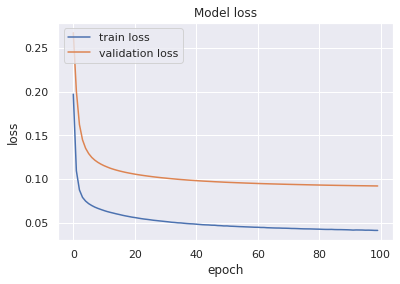

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [20,6]
plt.show()

## Predicting Test Data

In [ ]:
predictions = model.predict(test_X)
predictions.shape

(993, 200)

In [ ]:
def transform_predictions(pred_df, cols, scaler, n_days_future=30):
    pred_df = pred_df.reshape(-1, len(cols) * n_days_future)

    # np array to df
    denormalized = scaler.inverse_transform(pred_df)
    pred_df = denormalized.reshape((n_days_future, len(cols)))
    pred_df = pd.DataFrame(pred_df, columns=cols)

    return pred_df

## Transforming Predictions

In [ ]:
preds = transform_predictions(predictions[0], df.columns, scaler_target, n_days_future=20)['ftseclose']
tests = transform_predictions(test_y[1], df.columns, scaler_target, n_days_future=20)['ftseclose']

testing = df[['ftseclose','ftselow', 'ftsehigh']][-20:]
testing['pred'] = preds.values

## Plotting Results

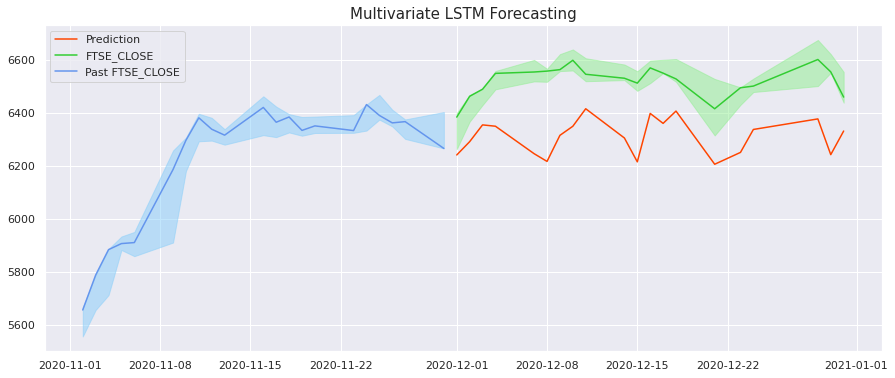

In [ ]:
f, ax = plt.subplots(figsize=(15,6))

past = df[(df.index >= "2020-11-01") & (df.index < "2020-12-01")][['ftseclose', 'ftsehigh', 'ftselow']]
ax.plot(testing[['pred']], color = 'orangered', label='Prediction')
ax.plot(testing[['ftseclose']], color = 'limegreen', label='FTSE_CLOSE')
ax.plot(past[['ftseclose']], color = 'cornflowerblue', label='Past FTSE_CLOSE')


# ax.fill_between(test.ds, test.pred_lower, test.pred_upper, color='lightcoral', alpha=0.5)
ax.fill_between(testing.index, testing.ftselow, testing.ftsehigh, color='lightgreen', alpha=0.5)
ax.fill_between(past.index, past.ftselow, past.ftsehigh, color='lightskyblue', alpha=0.5)

ax.set_title("Multivariate LSTM Forecasting", size = 15)
ax.legend()

plt.show()

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(testing.ftseclose, testing.pred)

Evaluation metric results:-
MSE is : 48901.63819992542
MAE is : 211.12333984375
RMSE is : 221.13714794200774
MAPE is : 3.2336531261273076
R2 is : -14.732721573657916

